In [1]:
import argparse
from collections import OrderedDict
import datetime
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pylab as plt
from numbers import Number
import numpy as np
import pandas as pd
import gc
pd.options.display.max_rows = 1500
pd.options.display.max_columns = 200
pd.options.display.width = 1000
pd.set_option('max_colwidth', 400)
import pdb
import pickle
import pprint as pp
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from deepsnap.batch import Batch as deepsnap_Batch

import sys, os
sys.path.append(os.path.join(os.path.dirname("__file__"), '..'))
sys.path.append(os.path.join(os.path.dirname("__file__"), '..', '..'))
from le_pde.argparser import arg_parse
from le_pde.datasets.load_dataset import load_data
from le_pde.models import load_model
from le_pde.pytorch_net.util import groupby_add_keys, filter_df, get_unique_keys_df, Attr_Dict, Printer, get_num_params, get_machine_name, pload, pdump, to_np_array, get_pdict, reshape_weight_to_matrix, ddeepcopy as deepcopy, plot_vectors, record_data, filter_filename, Early_Stopping, str2bool, get_filename_short, print_banner, plot_matrices, get_num_params, init_args, filter_kwargs, to_string, COLOR_LIST
from le_pde.utils import update_legacy_default_hyperparam, EXP_PATH, deepsnap_to_pyg, LpLoss, to_cpu, to_tuple_shape, parse_multi_step, loss_op, get_device, get_data_next_step
from utils import compute_pressForce
#from le_pde.utils import deepsnap_to_pyg, LpLoss, to_cpu, to_tuple_shape, parse_multi_step, loss_op, get_device, get_data_next_step

device = torch.device("cuda:0")
p = Printer()

/dfs/user/user279/miniconda3/envs/lepde/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pygame 2.5.1 (SDL 2.28.2, Python 3.9.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


## 1. Functions:

In [2]:
def plot_learning_curve(data_record):
    x_axis = np.arange(len(data_record["train_loss"]))
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(x_axis, data_record["train_loss"], label="train")
    plt.plot(x_axis, data_record["val_loss"], label="val")
    plt.plot(x_axis, data_record["test_loss"], label="test")
    plt.legend()
    plt.subplot(1,2,2)
    plt.semilogy(x_axis, data_record["train_loss"], label="train")
    plt.semilogy(x_axis, data_record["val_loss"], label="val")
    plt.semilogy(x_axis, data_record["test_loss"], label="test")
    plt.legend()
    plt.show()

## 2. Load Data:

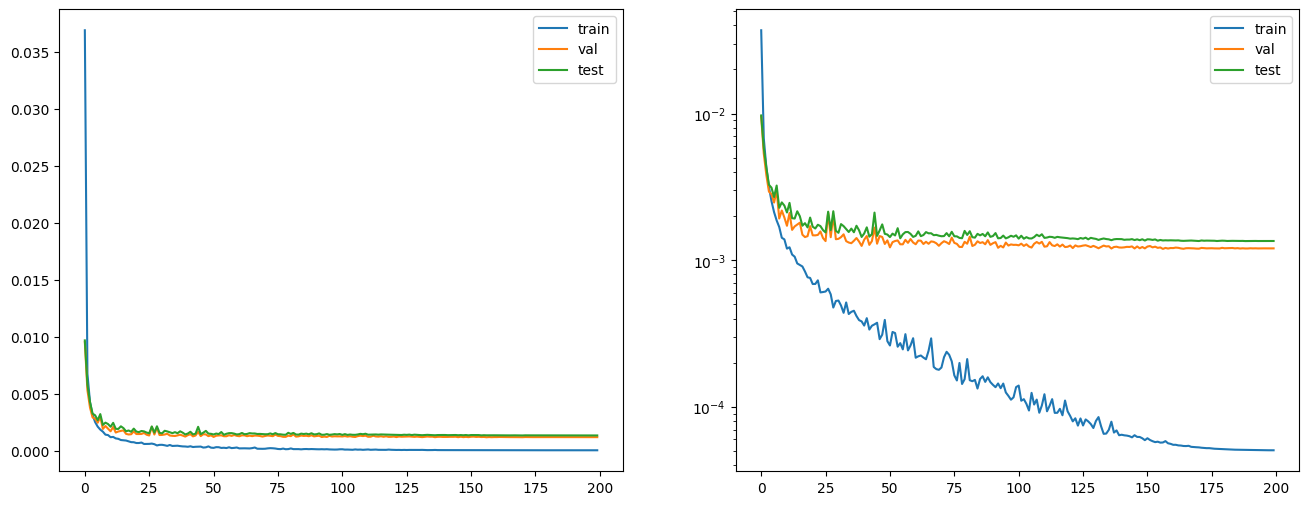

[2023-09-25 02:53:23] ['naca_ellipse_lepde_train_-1_algo_fno-m24-w40_enc_cnn-s_evo_cnn_act_silu_hid_32_lo_mse_recef_1.0_conef_1.0_nconv_4_nlat_1_clat_3_nl_False_lf_True_reg_None_gpu:0_id_0_Hash_clnAWVnz_hyperturing1.p']
[2023-09-25 02:53:23] ./dataset/deepsnap/naca_ellipse_lepde_test_in_4_out_1_itv_4.p does not exist. Generating...
self.time_stamps_effective:  45 200 16 4 4
Processing...
Done!
[2023-09-25 02:53:24] :
[2023-09-25 02:53:28] 500
[2023-09-25 02:53:33] 1000
[2023-09-25 02:53:38] 1500
[2023-09-25 02:53:43] 2000
[2023-09-25 02:53:47] 2500
[2023-09-25 02:53:52] 3000
[2023-09-25 02:53:57] 3500
[2023-09-25 02:54:02] 4000
[2023-09-25 02:54:07] 4500
[2023-09-25 02:54:11] 5000
[2023-09-25 02:54:16] 5500
[2023-09-25 02:54:21] 6000
[2023-09-25 02:54:25] 6500
[2023-09-25 02:54:30] 7000
[2023-09-25 02:54:35] 7500
[2023-09-25 02:54:40] 8000
[2023-09-25 02:54:45] 8500
[2023-09-25 02:54:50] 9000
[2023-09-25 02:55:14] saved generated deepsnap dataset to ./dataset/deepsnap/naca_ellipse_lepd

In [3]:
EXP_PATH = "./results/"

isplot = True
all_hash = [
    "clnAWVnz_hyperturing1",
]
hash_str = all_hash[0]
dirname = EXP_PATH + "naca_ellipse_2023-06-02/"
filename = filter_filename(dirname, include=hash_str)
if len(filename) == 0:
    raise

try:
    data_record = pload(dirname + filename[0])
except Exception as e:
    print(f"error {e}")
    # continue
    raise
if isplot:
    plot_learning_curve(data_record)
args = init_args(update_legacy_default_hyperparam(data_record["args"]))
args.filename = filename
model = load_model(data_record["model_dict"][-1], device=device)
model.eval()
p.print(filename, banner_size=100)

# Load test dataset:
args_test = deepcopy(args)
if args.temporal_bundle_steps == 1:
    if args.dataset in ["fno", "fno-2", "fno-3"]:
        args_test.multi_step = "20"
    elif args.dataset in ["fno-1"]:
        args_test.multi_step = "40"
    elif args.dataset in ["fno-4"]:
        args_test.multi_step = "10"
    elif args.dataset in ["naca_ellipse_lepde"]:
        args_test.multi_step = "1"
        args_test.latent_multi_step="1"
    else:
        raise
else:
    pass
args_test.batch_size = 1
args_test.is_test_only=True

(dataset_train_val, dataset_test), (train_loader, val_loader, test_loader) = load_data(args_test)
test_loader = DataLoader(dataset_test, num_workers=0, collate_fn=deepsnap_Batch.collate(),
                         batch_size=1, shuffle=False, drop_last=False)

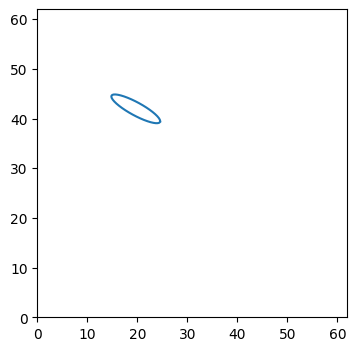

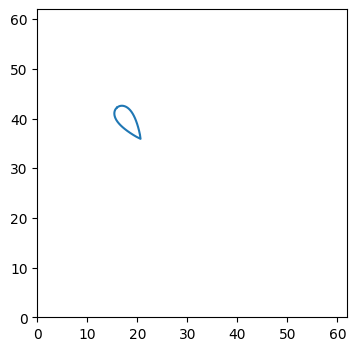

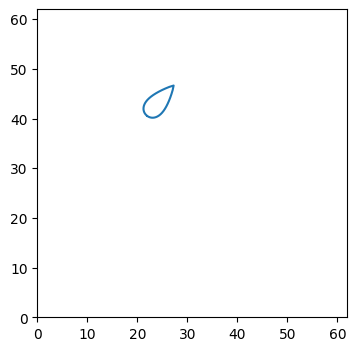

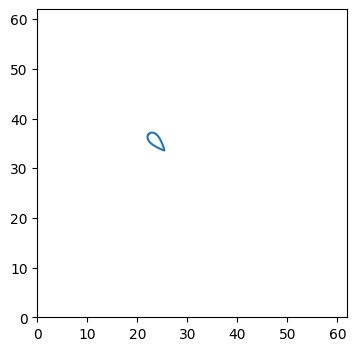

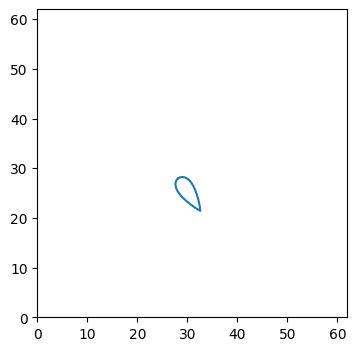

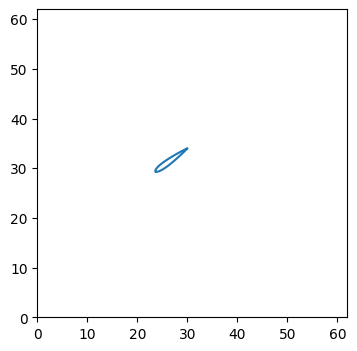

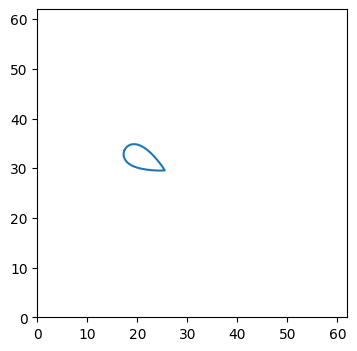

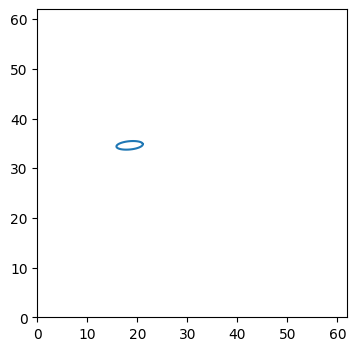

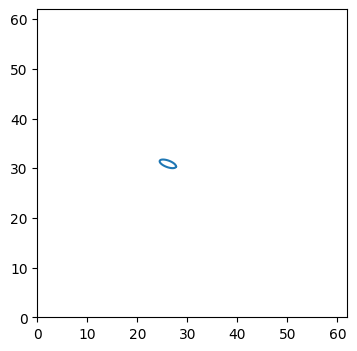

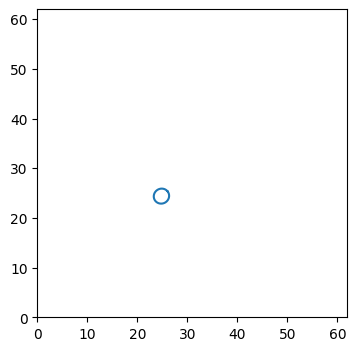

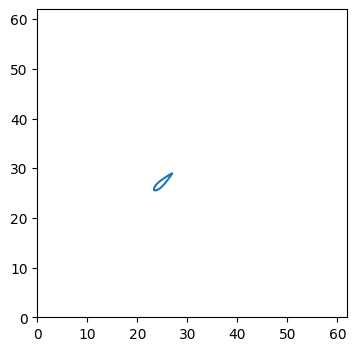

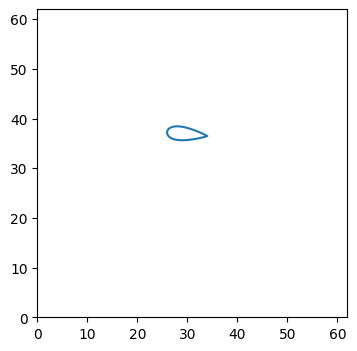

In [4]:
i=0
for data in test_loader:
    # if i == 1900:
    # if i == 2500:
    if i == 1200:
    # if i == 0:
    # if i == 400:
        break
    i+=1

    if i%100 == 0:
        fig, ax = plt.subplots(figsize=(4,4), ncols=1)
        bd = (((data.param["n0"].detach().cpu().numpy()/2) + 0.5) * 62) + 0
        mappable0 = ax.plot(bd[0,0::2], bd[0,1::2])
        ax.set_xlim(0, 62)
        ax.set_ylim(0, 62)
        plt.show()

In [5]:
data.to(device)        
testdata = data.clone()

In [6]:
m = 64; n=64
maxnum = 100

def discretize_boundary(boundary):
    assert boundary.shape[1] == 2
    num_bound = boundary.shape[0]
    device = boundary.device
    p_5 = torch.tensor([0.5], device=device).repeat(num_bound)
    x = torch.minimum(torch.maximum(boundary[:, 0], p_5), torch.tensor([n-1.5], device=device).repeat(num_bound))
    x_inds = torch.minimum(x.type(torch.int32), torch.tensor([n-2], device=device).repeat(num_bound))

    y = torch.minimum(torch.maximum(boundary[:, 1], p_5), torch.tensor([m-1.5], device=device).repeat(num_bound))
    y_inds = torch.minimum(y.type(torch.int32), torch.tensor([m-2], device=device).repeat(num_bound))
    return x_inds, y_inds

def find_orthogonal_line(A, B, C, x0, y0):
    m1 = torch.empty((C.shape[0],), device=C.device)
    m1[B==0] = float('inf')
    m1[B!=0] = (-A/B)[B!=0]

    m2 = torch.empty((C.shape[0],), device=C.device)
    m2[m1==float('inf')] = 0
    m2[m1!=float('inf')] = (-1 / m1)[m1!=float('inf')]

    b2 = y0 - m2 * x0  # The y-intercept of L2.

    # Return the coefficients A, B, C of the line L2 (Ax + By - C = 0)
    return m2, -1, b2

def edge_cells(polygon):
    num_vertices = len(polygon)
    edges = []
    for i in range(num_vertices):
        v1 = polygon[i]
        v2 = polygon[(i + 1) % num_vertices]
        edge = sorted([v1, v2], key=lambda x: x[1])
        edges.append(edge)
    return edges

def find_cells_inside_curve(polygon, grid_shape):
    def horizontal_intersection(x1, y1, x2, y2, y):
        return x1 + (y - y1) * (x2 - x1) / (y2 - y1)
    edges = edge_cells(polygon)
    grid = np.zeros(grid_shape, dtype=np.uint8)
    height, width = grid.shape
    
    for y in range(height):
        intersections = []
        for edge in edges:
            y1, y2 = edge[0][1], edge[1][1]
            if y1 < y <= y2:
                x = horizontal_intersection(*edge[0], *edge[1], y)
                intersections.append(x)
        intersections.sort()
        for i in range(0, len(intersections), 2):
            x_start, x_end = int(np.ceil(intersections[i])), int(np.floor(intersections[i + 1]))
            grid[y, x_start : x_end + 1] = 1

    return grid

In [7]:
def update_static_masks(torch_con_boundary):
    x_inds, y_inds = discretize_boundary(torch_con_boundary)
    pointy_hash = maxnum*x_inds[20] + y_inds[20]

    indices = torch.stack((maxnum*x_inds,y_inds), 0)
    sum_indices = indices.sum(0)
    ind_unique = torch.unique(sum_indices, sorted=True) #, return_inverse=True)
    x_idx = (torch.cat([(sum_indices==ind_u).nonzero()[0] for ind_u in ind_unique])).sort()[0]
    repeat_sum_indices = torch.tile(sum_indices, (ind_unique.shape[0],1))
    repeat_ind_unique = torch.tile(sum_indices[x_idx].reshape(ind_unique.shape[0], 1), (1, sum_indices.shape[0]))
    org_mask = (repeat_ind_unique == repeat_sum_indices)
    fatted_mask = torch.roll(org_mask, 1, 1) + torch.roll(org_mask, -1, 1)

    relvecs = []
    base_pts = []
    base_nums = []
    for bdpt in range(sum_indices[x_idx].shape[0]):
        if pointy_hash == sum_indices[x_idx][bdpt]:
            base_pt = torch.stack([x_inds[org_mask[bdpt]][0], y_inds[org_mask[bdpt]][0]]) + 0.5
            base_pts.append(base_pt)
            relvec = torch_con_boundary[20] - base_pt
            relvecs.append(relvec)
        elif torch.sum(org_mask[bdpt]) >= 4:
            base_pt = torch.stack([x_inds[org_mask[bdpt]][0], y_inds[org_mask[bdpt]][0]]) + 0.5
            base_pts.append(base_pt)
            relvec = torch_con_boundary[org_mask[bdpt]] - base_pt.repeat(torch_con_boundary[org_mask[bdpt]].shape[0], 1)
            ind = torch.argmin(torch.norm(relvec, dim=1))
            relvecs.append(relvec[ind])
        elif torch.sum(fatted_mask[bdpt] * torch.logical_not(org_mask[bdpt])) > 2:
            base_pt = torch.stack([x_inds[org_mask[bdpt]][0], y_inds[org_mask[bdpt]][0]]) + 0.5
            relvec = torch_con_boundary[org_mask[bdpt]] - base_pt.repeat(torch_con_boundary[org_mask[bdpt]].shape[0], 1)
            if len(relvec.shape) == 2:
                relvecs.append(relvec[-1])
                base_pts.append(base_pt)
            else:
                relvecs.append(relvec)
                base_pts.append(base_pt)
        elif torch.sum(org_mask[bdpt]) == 1:
            base_pt = torch.stack([x_inds[org_mask[bdpt]][0], y_inds[org_mask[bdpt]][0]]) + 0.5
            base_pts.append(base_pt)
            relvec = torch_con_boundary[org_mask[bdpt]] - base_pt
            relvecs.append(relvec[0])
        else:    
            if fatted_mask[bdpt][0] and fatted_mask[bdpt][-1]:
                rollnum = 1
                for _ in range(0, 100):
                    temprole = torch.roll(fatted_mask[bdpt], rollnum, 0)
                    if temprole[0] and temprole[-1]:
                        rollnum += 1    
                    else:
                        break
                x_pts = torch.roll(torch_con_boundary[fatted_mask[bdpt]], rollnum, 0)            
            else:
                x_pts = torch_con_boundary[fatted_mask[bdpt]]

            bd_points = torch.cat([x_pts[0:1], x_pts[1:-1].repeat(1, 2).reshape(-1,2), x_pts[-1:]], dim=0)
            dire_vec = bd_points[0::2] - bd_points[1::2]
            const = bd_points[0::2, 1] - bd_points[0::2, 0] * dire_vec[:,1]/dire_vec[:,0]

            base_pt = torch.stack([x_inds[org_mask[bdpt]][0], y_inds[org_mask[bdpt]][0]]) + 0.5
            base_pts.append(base_pt)
            base_points = base_pt.repeat(const.shape[0], 1)
            slope = dire_vec[:,1]/dire_vec[:,0]
            ax, by, con = find_orthogonal_line(slope, -torch.ones((const.shape[0],), device=torch_con_boundary.device), const, base_points[:,0], base_points[:,1])

            al = -ax/by
            bl = con
            cl = dire_vec[:,1]/dire_vec[:,0]
            dl = const

            intersection = torch.stack([(dl - bl)/(al - cl), (al*dl - bl*cl)/(al - cl)]).t()

            relvec = intersection - torch.tile(base_pt, (intersection.shape[0], 1))
            relvecs.append(relvec.sum(0)/relvec.shape[0])

    ### Check number of offset vectors is same as that of boundary cells of solid
    assert len(base_pts) == sum_indices[x_idx].shape[0]
    
    bd_offset = torch.stack(relvecs)
    offset_grid_bound = torch.zeros((62, 62, 2), device=torch_con_boundary.device)
    offset_grid_bound[x_inds, y_inds] = torch.tensor([1, 1], dtype=torch.float32, device=torch_con_boundary.device)
    offset_grid_bound = offset_grid_bound.transpose(1,0)

    offset_grid = find_cells_inside_curve(torch.stack((x_inds, y_inds), -1).detach().cpu().tolist(), (62, 62))
    inner_solid_mask = np.copy(offset_grid)
    offset_grid = offset_grid.reshape(62, 62, 1)
    offset_grid = np.concatenate([offset_grid, offset_grid], -1)

    offset_union = offset_grid_bound + torch.tensor(offset_grid, device=torch_con_boundary.device)
    offset_union[(offset_union.sum(-1) > 2),:] = torch.tensor([1, 1], dtype=torch.float32, device=torch_con_boundary.device)
    offset_union.index_put_((y_inds[x_idx], x_inds[x_idx]), bd_offset)    

    grid_bound = torch.zeros((62, 62), device=torch_con_boundary.device)
    grid_bound[x_inds, y_inds] = 1
    union = grid_bound.transpose(1,0) + torch.tensor(inner_solid_mask, device=torch_con_boundary.device)
    union[union == 2] = 1

    updated_solid_mask = union
    
    return updated_solid_mask, offset_union 

## 3. inverse optimization with FNO

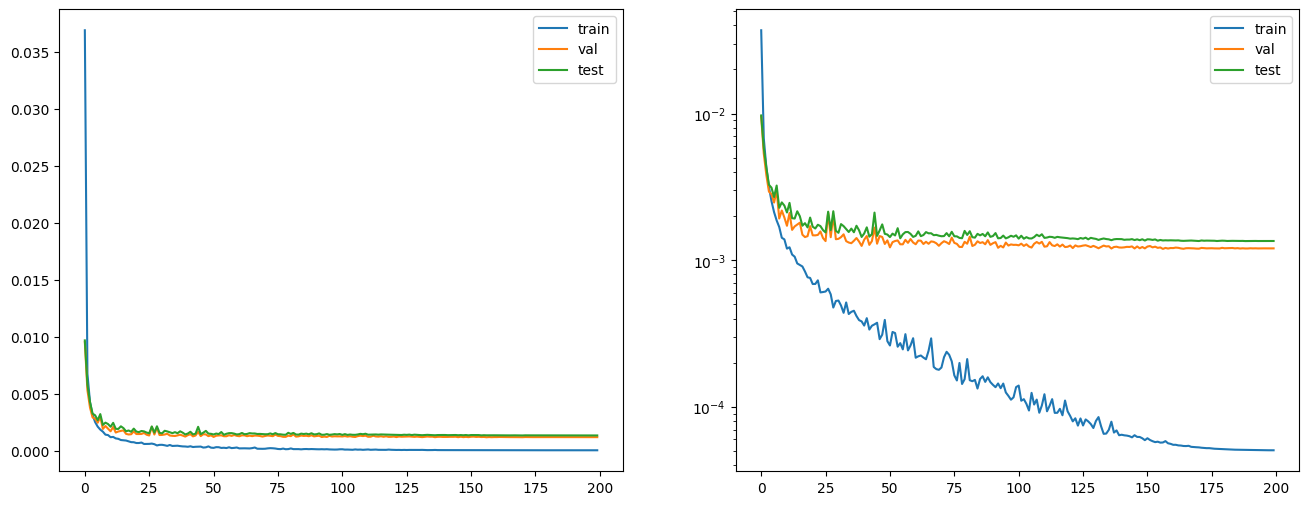

[2023-09-25 02:56:15] ['naca_ellipse_lepde_train_-1_algo_fno-m24-w40_enc_cnn-s_evo_cnn_act_silu_hid_32_lo_mse_recef_1.0_conef_1.0_nconv_4_nlat_1_clat_3_nl_False_lf_True_reg_None_gpu:0_id_0_Hash_clnAWVnz_hyperturing1.p']


In [8]:
isplot = True
all_hash = [
    #"Yirzlp+j_ampere4",
    "clnAWVnz_hyperturing1",
]
hash_str = all_hash[0]
dirname = EXP_PATH + "naca_ellipse_2023-06-02/"
filename = filter_filename(dirname, include=hash_str)
if len(filename) == 0:
    raise

try:
    data_record = pload(dirname + filename[0])
except Exception as e:
    print(f"error {e}")
    raise
if isplot:
    plot_learning_curve(data_record)
args = init_args(update_legacy_default_hyperparam(data_record["args"]))
args.filename = filename
model_fno = load_model(data_record["model_dict"][-1], device=device)
model_fno.eval()
p.print(filename, banner_size=100)

# Load test dataset:
args_test = deepcopy(args)
if args.temporal_bundle_steps == 1:
    if args.dataset in ["fno", "fno-2", "fno-3"]:
        args_test.multi_step = "20"
    elif args.dataset in ["fno-1"]:
        args_test.multi_step = "40"
    elif args.dataset in ["fno-4"]:
        args_test.multi_step = "10"
    elif args.dataset in ["naca_ellipse_lepde"]:
        args_test.multi_step = "1"
        args_test.latent_multi_step="1"
    else:
        raise
else:
    pass
args_test.batch_size = 1
args_test.is_test_only=True


In [199]:
normalization_filename = os.path.join("./dataset/naca_ellipse/training_trajectories/", "normalization_max_min.p")
normdict = pickle.load(open(normalization_filename, "rb"))
x_max = normdict["x_max"]
x_min = normdict["x_min"]
y_max = normdict["y_max"]
y_min = normdict["y_min"]
p_max = normdict["p_max"]
p_min = normdict["p_min"]
p_max = p_max.to(device)
p_min = p_min.to(device)

In [228]:
import pdb
from matplotlib.backends.backend_pdf import PdfPages
from utils import compute_orthonormal, linear_transform, compute_pressForce, compute_orthonormal

def update_bdfeature (reconstructed_boundary):
    upd_solid_mask, upd_solid_offset = update_static_masks(reconstructed_boundary)
    torch_batch_mask = torch.where(upd_solid_mask==1, False, True).clone().flatten()
    upd_solid_mask = upd_solid_mask[...,None]
    static_feature = torch.cat((upd_solid_mask, upd_solid_offset), -1)
    multi_static_feat = torch.stack([static_feature for _ in range(4)], -2).reshape(-1,4,3)
    return multi_static_feat, torch_batch_mask

# Hyper parameter for CEM


orgdata = data.clone()
testdata = data.clone()

opt_mask = testdata.node_feature["n0"][:,-2:-1,0:1].detach().clone()
opt_offset = testdata.node_feature["n0"][:,-2:-1,1:3].detach().clone()

# soft_mask_body = torch.tensor([0.99 if opt_mask.flatten()[for _ in range(62*62)], device=opt_mask.device).reshape(opt_mask.shape)
# soft_mask_body.requires_grad = True

# soft_mask_nonbody = torch.tensor([0.01 for _ in range(62*62)], device=opt_mask.device).reshape(opt_mask.shape)
# soft_mask_nonbody.requires_grad = True

# soft_opt_mask = soft_mask_body.clone()
# soft_opt_mask[opt_mask==0] = soft_mask_nonbody[opt_mask==0]
mask_list = []
for i in range(62*62):
    if opt_mask.flatten()[i] == 1:
        mask_list.append([[0.99]])
    else:    
        mask_list.append([[0.01]])
soft_opt_mask = torch.tensor(mask_list, device=opt_mask.device)
soft_opt_mask.requires_grad = True

cat_opt_mask = torch.concat([opt_mask, opt_offset], -1)
static_grid = torch.concat([cat_opt_mask for _ in range(4)], -2)
dynamic_features = testdata.node_feature["n0"][:,:,3:].detach().clone()

testdata.node_feature["n0"] = torch.concat([static_grid, dynamic_features], -1)

num_elite = 3
num_sample = 50
smoothing_coef = 0.001

optim_iter = 3000
optim_iter_mask = 100


# prerollout = 36
prerollout = 20
one_period = 4
vis_prerollout = False
stds = torch.where(opt_offset.clone()==1, 0.01, 0.01)

optimizer_mask = torch.optim.Adam([soft_mask_body, soft_mask_nonbody], lr=0.001)
optimizer_offset = torch.optim.Adam([opt_offset], lr=0.001)

In [229]:
output = - (per==True).sum() * (torch.log(p)) - (per==False).sum() * torch.log(1 - p)
optimizer_mask.zero_grad()
output.backward()
# torch.nn.utils.clip_grad_value_(opt_variable, 0.01)
optimizer_mask.step()

p

tensor(0.6682, device='cuda:0', requires_grad=True)

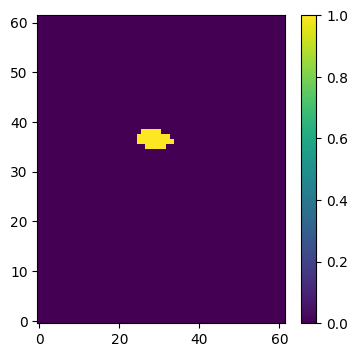

In [231]:
fig, ax = plt.subplots(figsize=(4,4), ncols=1)
mappable = ax.imshow(opt_mask.reshape(62,62).detach().cpu().numpy(), cmap='viridis',
         aspect='auto',
         origin='lower')
fig.colorbar(mappable, ax=ax)
plt.show()

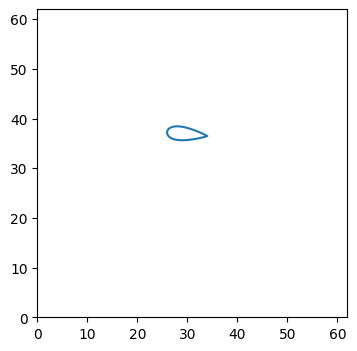

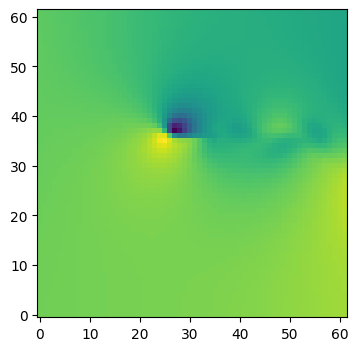

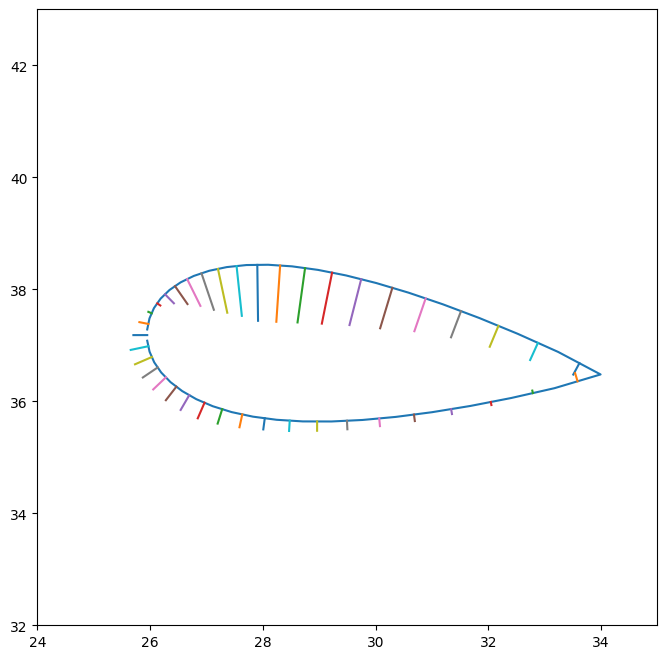

iteration:  9


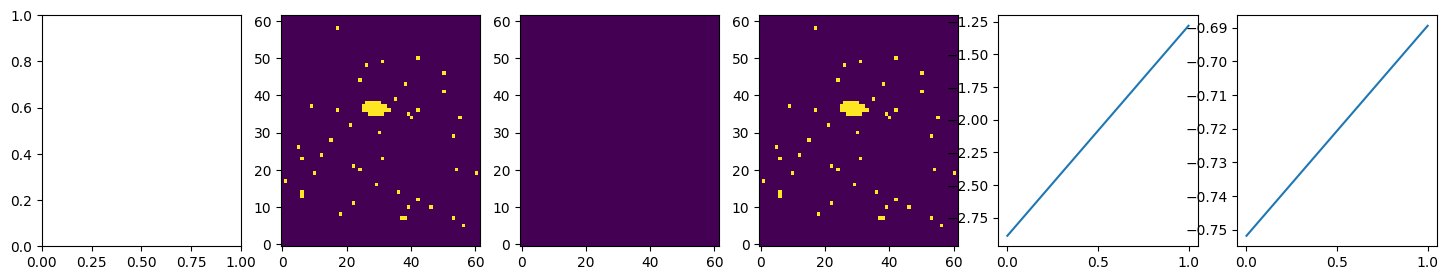

iteration:  19


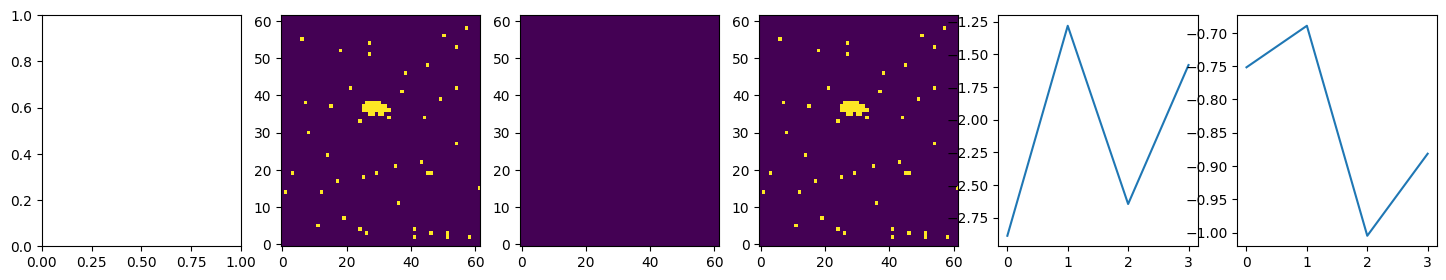

iteration:  29


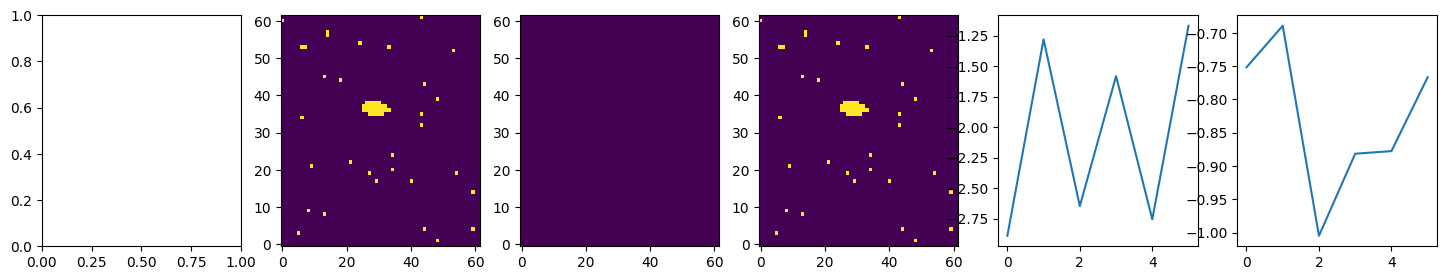

iteration:  39


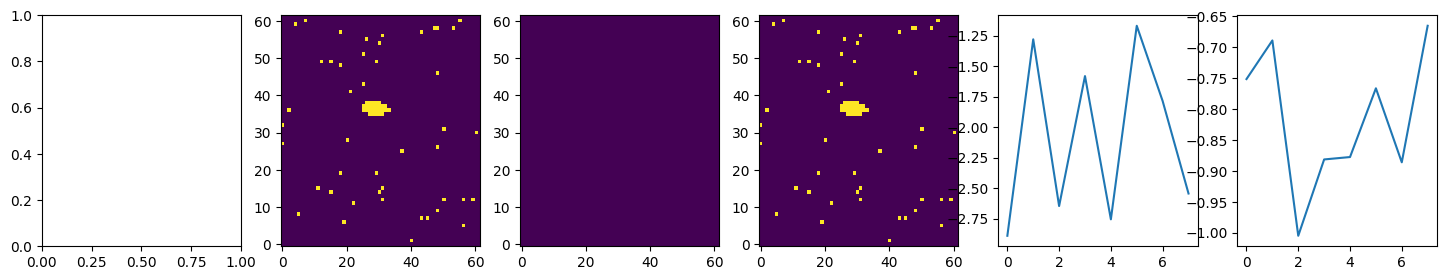

iteration:  49


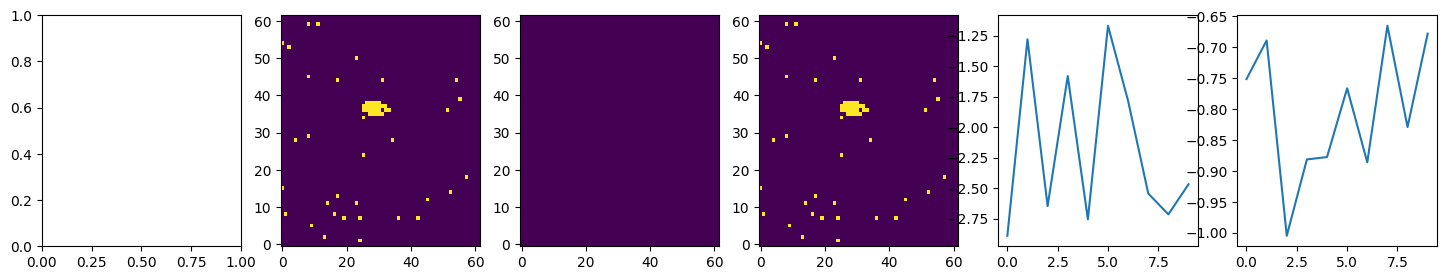

iteration:  59


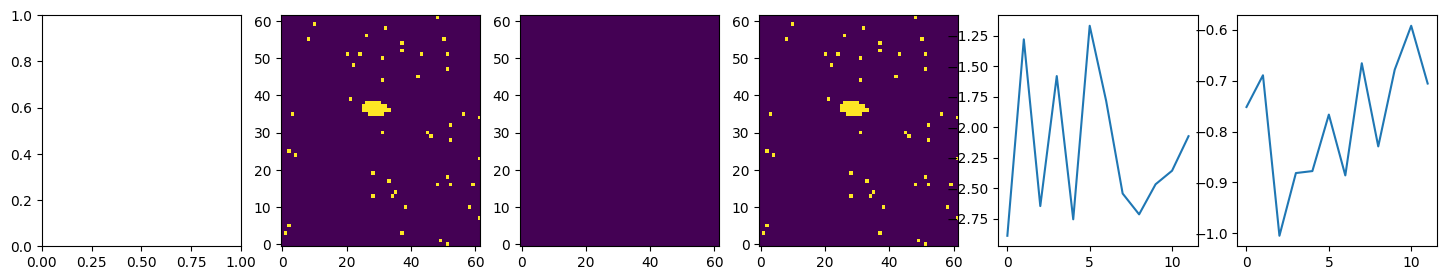

iteration:  69


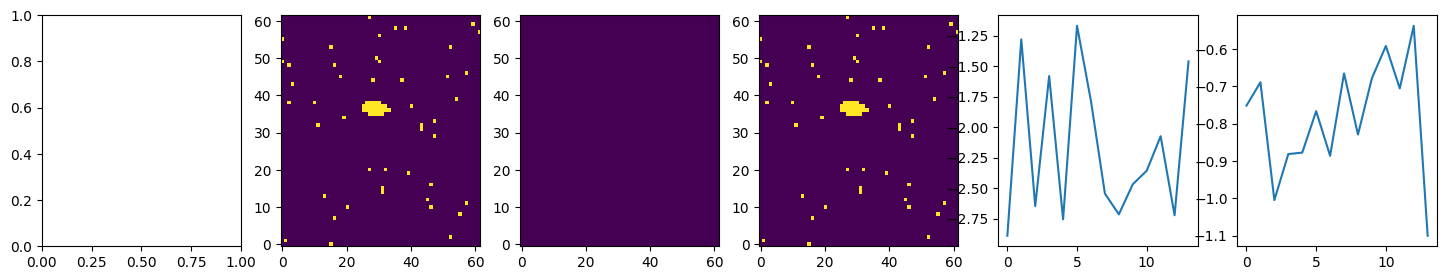

iteration:  79


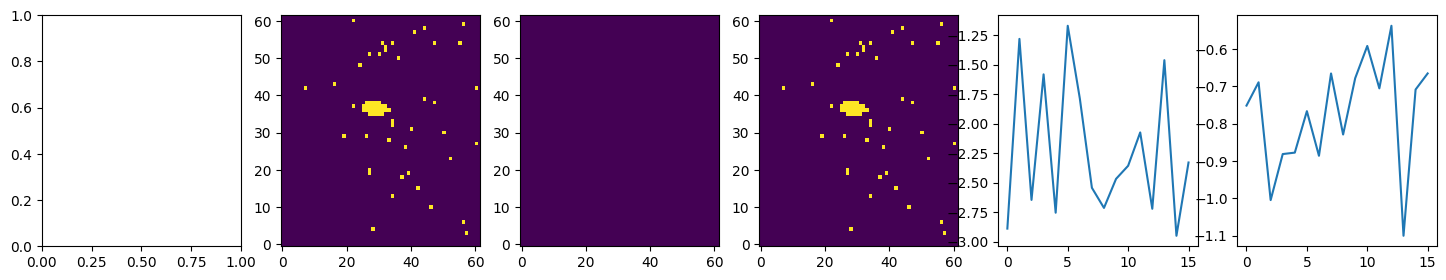

iteration:  89


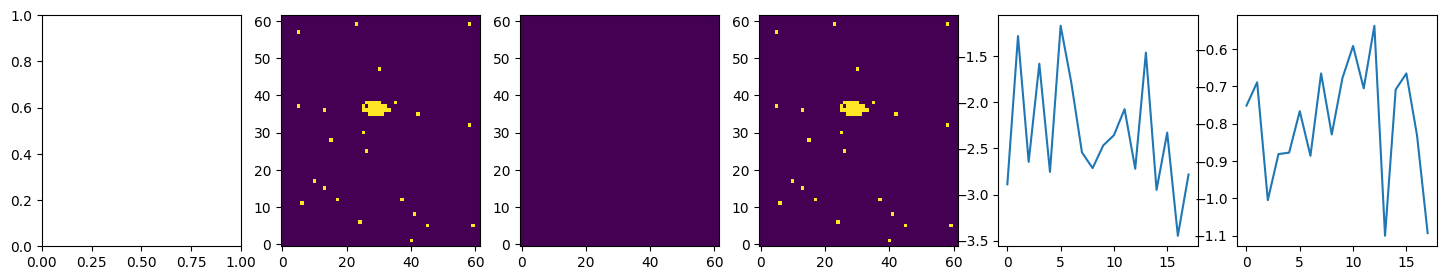

iteration:  99


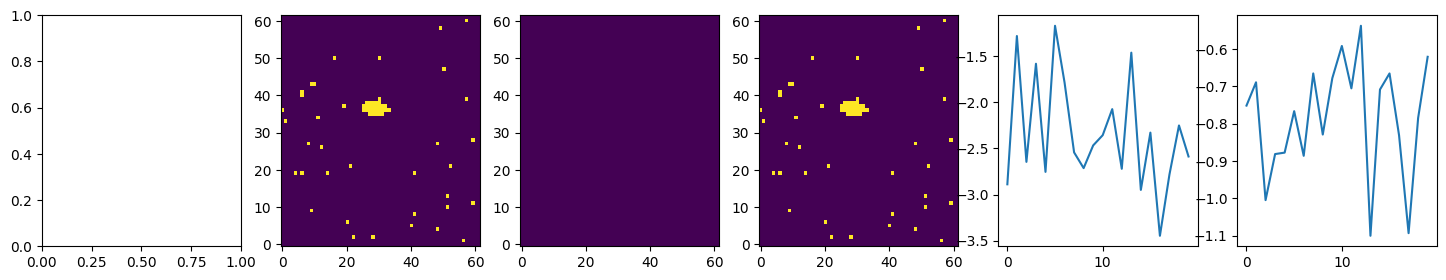

iteration:  109


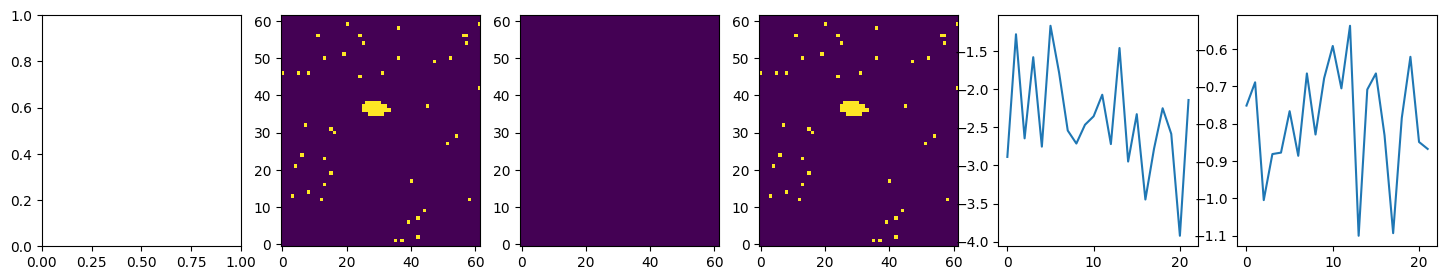

iteration:  119


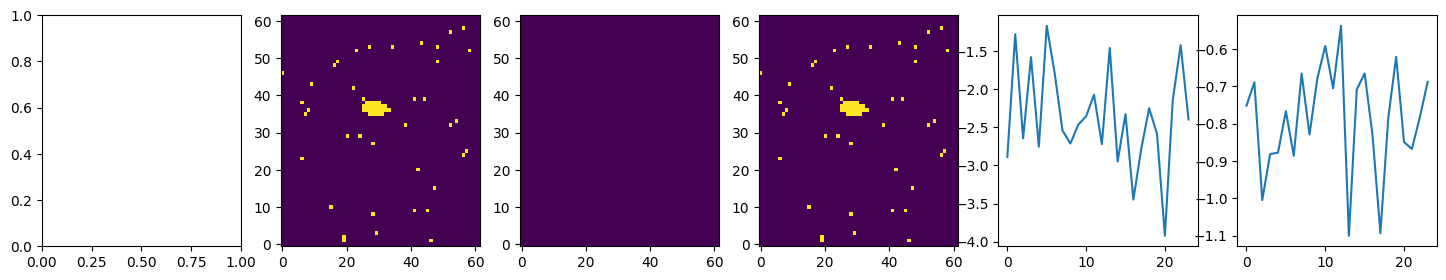

iteration:  129


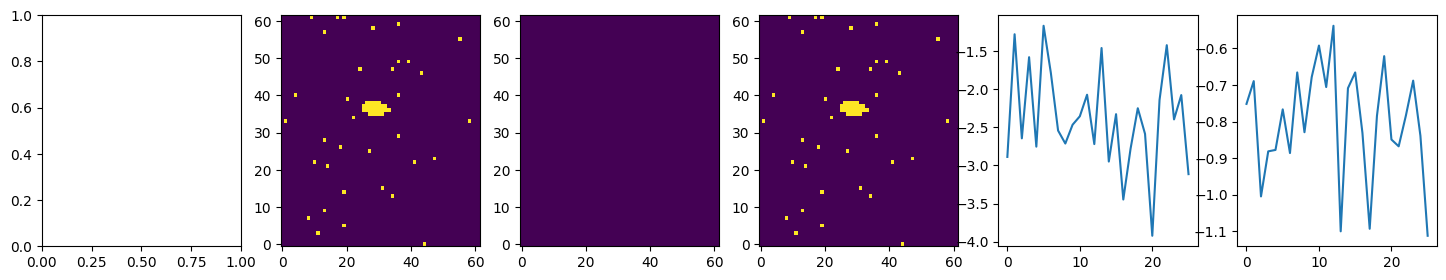

iteration:  139


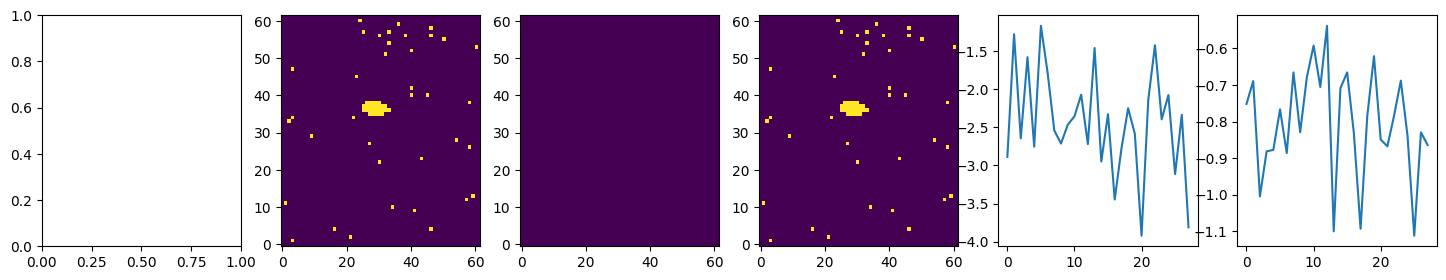

iteration:  149


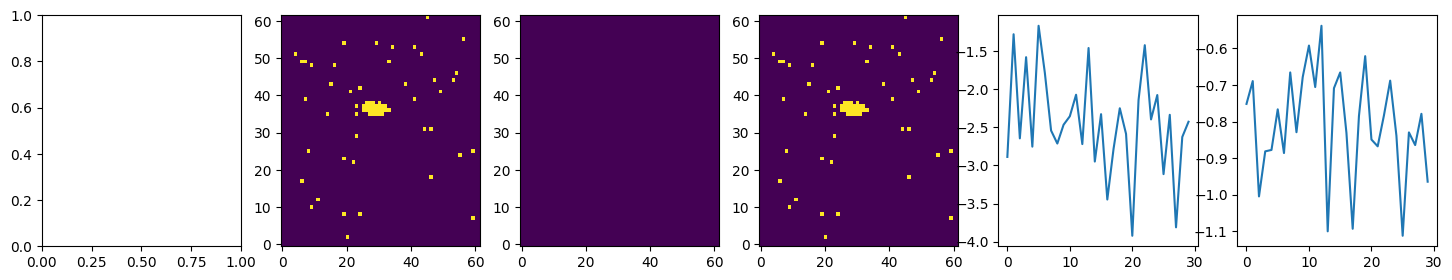

iteration:  159


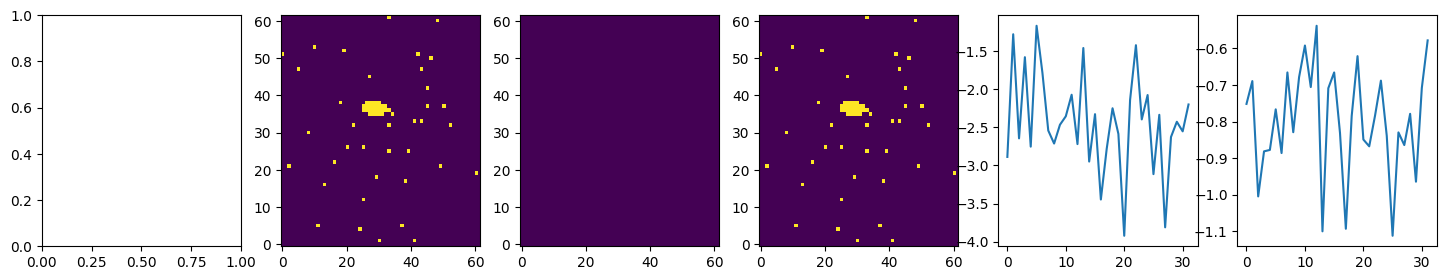

iteration:  169


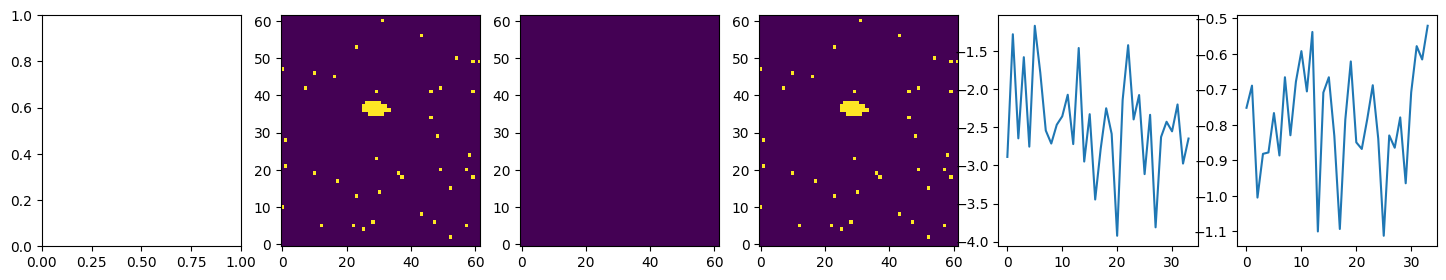

KeyboardInterrupt: 

In [232]:
# Plot initial boundary
fig, ax = plt.subplots(figsize=(4,4), ncols=1)
bd = testdata.param["n0"].reshape(40,2).detach().cpu().numpy()
bd = (((bd/2) + 0.5) * 62) + 0
mappable0 = ax.plot(bd[:,0], bd[:,1])
ax.set_xlim(0, 62)
ax.set_ylim(0, 62)
plt.show()

# Visualize input pressure
fig, ax = plt.subplots(figsize=(4,4), ncols=1)
ax.imshow(testdata.node_feature["n0"][:,-1,-1].reshape(62,62).detach().cpu().numpy(), cmap='viridis',
         aspect='auto',
         origin='lower')
plt.show()

# Plot initial boundary with normal vectors
fig, ax = plt.subplots(figsize=(8,8), ncols=1)
length, nx, ny, cen = compute_orthonormal(torch.tensor(bd))
rec_press = ((((testdata.node_label["n0"][:,-1,-1].reshape(62,62)/2) + 0.5) * (p_max-p_min)) + p_min).detach().cpu()
lin_press = linear_transform(torch.nn.functional.pad(rec_press, (1,3,1,3)), cen) #* (-1)
mappable0 = ax.plot(bd[:,0], bd[:,1])
normals = torch.stack((lin_press*nx,lin_press*ny), -1)
for i in range(40):
    rel_normals = cen[i,:] + normals[i,:]
    ax.plot((cen[i,0], rel_normals[0]), (cen[i,1], rel_normals[1]))
ax.set_xlim(24, 35)
ax.set_ylim(32, 43)
plt.show()

pdf = PdfPages('./optimized_naca_fno_CEM.pdf')
list_force = []
list_drag_force = []
for oiter in range(optim_iter):
    total_x_force = 0
    total_y_force = 0
    

    candidate_boundaries_offset = []
    candidate_boundaries_mask = []
    scores = []

    ### CEM Loop ###
    for s in range(num_sample):
        # Reconstruct boundary
        # bound = torch.cat((const_variable, opt_variable), 0).transpose(1,0).flatten()[None,:].reshape(40,2)
        # rec_bound = (((bound/2) + 0.5) * 62) + 0

        # Generate random sample for offset
        perturbed_boundary_mask = torch.bernoulli(soft_opt_mask)
        candidate_boundaries_mask.append(perturbed_boundary_mask)
        
        perturbed_boundary_offset = torch.normal(mean=opt_offset.clone(), std=stds)
        candidate_boundaries_offset.append(perturbed_boundary_mask)

        #Update boundary feature
        perturbed_mask = torch.concat([perturbed_boundary_mask, perturbed_boundary_offset], -1)
        static_grid = torch.concat([perturbed_mask for _ in range(4)], -2)
        dynamic_features = testdata.node_feature["n0"][:,:,3:].detach().clone()
        testdata.node_feature["n0"] = torch.concat([static_grid, dynamic_features], -1)
       
        ### Perform rollout ###
        final_objective = 0
        for kk in range(prerollout+one_period):
            if kk < prerollout:
                testdata, pred = get_data_next_step(model_fno, testdata, use_grads=False, return_data=True, is_y_diff=False)
                raw_bound = (((testdata.param["n0"].reshape(40,2)/2) + 0.5) * 62) + 0
            if kk == prerollout:
                length, nx, ny, cen = compute_orthonormal(raw_bound)
                cen = cen.to(device)       
            if kk >= prerollout:
                testdata, pred = get_data_next_step(model_fno, testdata, use_grads=False, return_data=True, is_y_diff=False)
                press = ((((pred["n0"].reshape(62, 62, 1, 3)[...,0,-1])/2) + 0.5) * (p_max-p_min)) + p_min
                x_force, y_force = compute_pressForce(torch.nn.functional.pad(press, (1,3,1,3)), raw_bound)
                final_objective += -1/x_force + 10 * torch.square(-7.5*one_period - y_force)
                
        scores.append(final_objective.item())

    index = torch.argsort(torch.tensor(scores))
    
    ### Select elite samples and compute next mean and variance ###
    elites_mask = torch.cat(candidate_boundaries_mask, dim=1)[:, index, :][:, :num_elite, :]
    for _ in range(optim_iter_mask):
        output_mask = (1/num_elite) * (-torch.log(torch.cat([soft_opt_mask for _ in range(num_elite)], dim=1)[elites_mask==1]).sum() - torch.log(1 - torch.cat([soft_opt_mask for _ in range(num_elite)], dim=1)[elites_mask==0]).sum())
        optimizer_mask.zero_grad()
        output_mask.backward()
        optimizer_mask.step()
            
    ### Smooth mean and variance ###
    elites_offset = torch.cat(candidate_boundaries_offset, dim=1)[:, index, :][:, :num_elite, :]
    next_mean = torch.mean(elites_offset, dim=1, keepdim=True)
    next_vari = torch.var(elites_offset, dim=1, correction=0, keepdim=True)
    opt_offset = smoothing_coef * torch.clamp(next_mean, -0.5, 0.5) + (1 - smoothing_coef) * opt_offset
    stds = smoothing_coef * next_vari + (1 - smoothing_coef) * stds
    
    # Generate random sample for offset
    opt_mask = torch.bernoulli(soft_opt_mask)                                                
    opt_offset = torch.normal(mean=opt_offset.clone(), std=stds)
                                                
    #Update boundary feature
    cat_opt_mask = torch.concat([opt_mask, opt_offset], -1)
    static_grid = torch.concat([cat_opt_mask for _ in range(4)], -2)
    dynamic_features = testdata.node_feature["n0"][:,:,3:].detach().clone()
    testdata.node_feature["n0"] = torch.concat([static_grid, dynamic_features], -1)

    ### Perform evaluation with updated boundary  ###
    for kk in range(prerollout+one_period):
        if kk < prerollout:
            testdata, pred = get_data_next_step(model_fno, testdata, use_grads=False, return_data=True, is_y_diff=False)
            # press = ((((pred["n0"].reshape(62, 62, 1, 3)[...,0,-1])/2) + 0.5) * (p_max-p_min)) + p_min
            raw_bound = (((testdata.param["n0"].reshape(40,2)/2) + 0.5) * 62) + 0
        if kk == prerollout:
            length, nx, ny, cen = compute_orthonormal(raw_bound)
            cen = cen.to(device)       
        if kk >= prerollout:
            testdata, pred = get_data_next_step(model_fno, testdata, use_grads=False, return_data=True, is_y_diff=False)
            press = ((((pred["n0"].reshape(62, 62, 1, 3)[...,0,-1])/2) + 0.5) * (p_max-p_min)) + p_min
            # lin_press = linear_transform(torch.nn.functional.pad(press, (1,3,1,3)), cen)
            x_force, y_force = compute_pressForce(torch.nn.functional.pad(press, (1,3,1,3)), raw_bound)
            ### Need to update, object should be defined here ###
            total_x_force += x_force
            total_y_force += y_force

    total_x_force = total_x_force/one_period
    total_y_force = total_y_force/one_period
            
    list_force.append(total_y_force.item())
    list_drag_force.append(total_x_force.item())


    ### Visualization of updated boundary """
    if oiter % 10 == 9:
        print("iteration: ", oiter)
#         bound = torch.cat((const_variable, opt_variable), 0).transpose(1,0).flatten()[None,:].reshape(40,2)
#         bd = (((bound.detach().cpu().numpy()/2) + 0.5) * 62) + 0        
#         length, nx, ny, cen = compute_orthonormal(torch.tensor(bd))

        fig, ax = plt.subplots(figsize=(18,3), ncols=6)
#         mappable0 = ax[0].plot(bd[:,0], bd[:,1])
#         nx = nx.detach().cpu()
#         ny = ny.detach().cpu()
#         cen = cen.detach().cpu()
#         lin_press = lin_press.cpu()
#         normals = torch.stack((lin_press*nx,lin_press*ny), -1)#.to(device)
#         for i in range(40):
#             rel_normals = cen[i,:] + normals[i,:]
#             ax[0].plot((cen[i,0].numpy(), rel_normals[0].detach().numpy()), (cen[i,1].numpy(), rel_normals[1].detach().numpy()))
#         ax[0].set_xlim(24, 35)
#         ax[0].set_ylim(32, 43)
        mappable1 = ax[1].imshow(testdata.node_feature["n0"][:,-1,0].reshape(62,62).detach().cpu().numpy(), cmap='viridis',
                                 aspect='auto',
                                 origin='lower')
        vis_offsetmask = torch.where(testdata.node_feature["n0"][:,-1,1]!=0, 1, 0)
        mappable2 = ax[2].imshow(vis_offsetmask.reshape(62,62).detach().cpu().numpy(), cmap='viridis',
                                 aspect='auto',
                                 origin='lower')        
        mappable3 = ax[3].imshow(testdata.node_feature["n0"][:,-1,0].reshape(62,62).detach().cpu().numpy()-vis_offsetmask.reshape(62,62).detach().cpu().numpy(), cmap='viridis',
                                 aspect='auto',
                                 origin='lower')        
        mappable4 = ax[4].plot(np.array(list_force)[0::5])
        mappable5 = ax[5].plot(np.array(list_drag_force)[0::5])
         # pdf.savefig()
        plt.show()
    

pdf.close()